In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
%pwd

/home/markus/Documents/regression-prediction


'/home/markus/Documents/regression-prediction'

In [3]:
from experiments.modeleval_utils import *

/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [20]:
# db7fd455cc6af66a965d3ee6f4b3c3a2d00f1a37
# ix = 87809
bug_ix = 59972

In [4]:
def print_classification_report_at_threshold(clf, X, y, threshold):
    y_score = get_y_score(clf, X)
    y_pred = y_score >= threshold
    print(f'{threshold=}')
    report = metrics.classification_report(y, y_pred)
    print(report)
    roc_auc = metrics.roc_auc_score(y, y_score)
    average_precision = metrics.average_precision_score(y, y_score)
    print(f'{roc_auc=} {average_precision=}')

In [5]:
def fit_best_model(model, data, feature_type, target, scoring, X_train, y_train):
    pipeline, best_params, best_result = get_pipeline(data, feature_type, target, scoring, model)
    pipeline.fit(X_train, y_train)
    return pipeline

In [6]:
import shap
def plot_important_features(clf, X, feature_names, max_display=10):
    explainer = shap.Explainer(clf, X, feature_names=feature_names)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, max_display=max_display, feature_names=feature_names)
    plt.show()

In [7]:
data = 'bugbug_buglevel'
scoring = 'average_precision'

In [8]:
feature_type = 'traditional' # traditional, bow

In [16]:
model = 'lr'
target = 'performance'

X, y, features = data_map[feature_type][data](target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

perf_pipeline = fit_best_model(model, data, feature_type, target, scoring, X_train, y_train)

performance: 1880 positive 2.77% - negative 66041 97.23%
X.shape=(67921, 302)



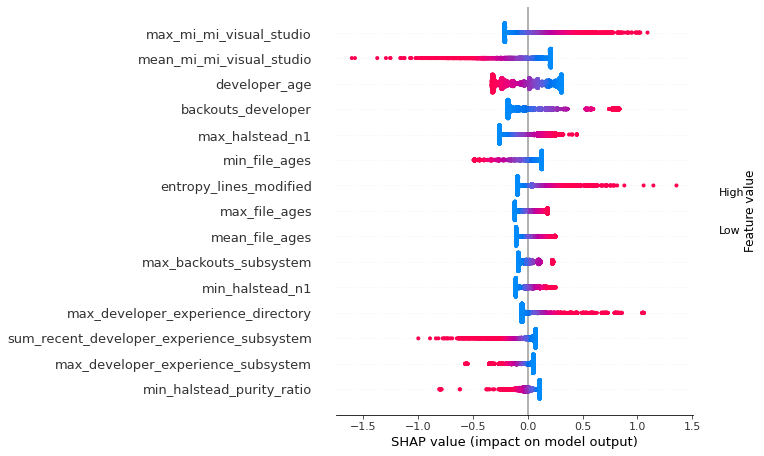

In [17]:
perf_model = perf_pipeline['model']

if feature_type == 'traditional':
    X_ = perf_pipeline['scaler'].transform(X_test)
    feature_names = features.columns
    # plot_important_features(perf_model, X_, features.columns, max_display=15)
else:
    X_ = X_test.toarray()
    feature_names = features
    # plot_important_features(perf_model, X_, features, max_display=15)

explainer = shap.Explainer(perf_model, X_, feature_names=feature_names)

shap_values = explainer.shap_values(X_)
shap.summary_plot(shap_values, X_, max_display=15, feature_names=feature_names)

# shap_values = explainer(X_)
#shap.beeswarm_plot(shap_values, max_display=15)

In [30]:
bug_x = X[bug_ix, :].reshape(1, -1)
bug_x = perf_pipeline['scaler'].transform(bug_x)

In [34]:
perf_model.predict_proba(bug_x)

array([[0.46548734, 0.53451266]])

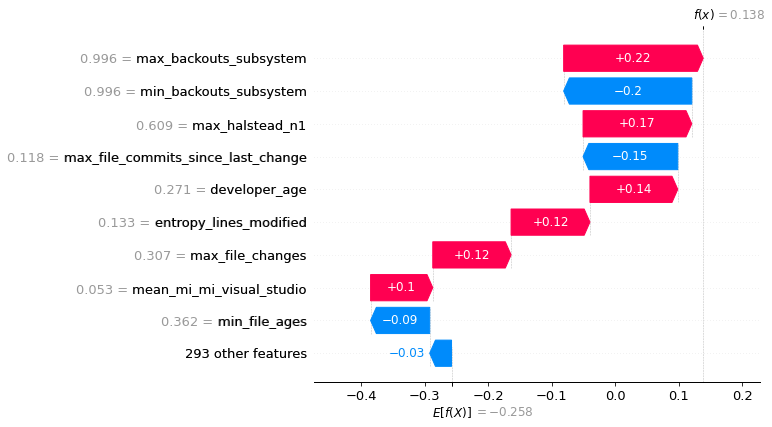

In [32]:
explainer = shap.Explainer(perf_model, X_, feature_names=feature_names)
shap_values = explainer(bug_x)
shap.waterfall_plot(shap_values[0])


In [ ]:
type(shap_values)

In [ ]:
plot_precision_recall_curve_with_f1(perf_pipeline, X_test, y_test)
t, f1 = get_best_f1_threshold(perf_pipeline, X_train, y_train)
print_classification_report_at_threshold(perf_pipeline, X_test, y_test, t)

In [ ]:
target = 'regression'

X, y, features = data_map[feature_type][data](target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

reg_pipeline = fit_best_model(model, data, feature_type, target, scoring, X_train, y_train)

In [ ]:
reg_model = reg_pipeline['model']

if feature_type == 'traditional':
    X_ = perf_pipeline['scaler'].transform(X_test)
    plot_important_features(perf_model, X_, features.columns, max_display=15)
else:
    X_ = X_test.toarray()
    plot_important_features(perf_model, X_, features, max_display=15)

In [ ]:
plot_precision_recall_curve_with_f1(reg_pipeline, X_test, y_test)
t, f1 = get_best_f1_threshold(reg_pipeline, X_train, y_train)
print_classification_report_at_threshold(reg_pipeline, X_test, y_test, t)

### Predict Performance on Regression Model

In [ ]:
data = 'bugbug_buglevel'
scoring = 'average_precision'

In [ ]:
feature_type = 'traditional' # traditional, bow

In [ ]:
model = 'xgb' # best regression model
target = 'regression'

X, y, features = data_map[feature_type][data](target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

reg_pipeline = fit_best_model(model, data, feature_type, target, scoring, X_train, y_train)

In [ ]:
X_perf, y_perf, features = data_map[feature_type][data]('performance')
X_perf_train, X_perf_test, y_perf_train, y_perf_test = train_test_split(X_perf, y_perf, test_size=0.1, shuffle=False)

perf_model = 'lr' # best performance model
perf_pipeline = fit_best_model(perf_model, data, feature_type, 'performance', scoring, X_perf_train, y_perf_train)

In [ ]:
# regression model evaluated on performance regressions
_ = plot_roc_auc_rec_prec_for_all_models(target, data, feature_type, scoring,
    [('Trained on performance regressions', perf_pipeline), ('Trained on all reggressions', reg_pipeline)],
    X_train, X_test, X_perf_test, y_perf_test, save=False, figsize=(6,4), ylim=[0,1.])

In [ ]:
# regression model evaluated on all regressions
_ = plot_roc_auc_rec_prec_for_all_models(target, data, feature_type, scoring,
    [('Trained on performance regressions', perf_pipeline), ('Trained on all reggressions', reg_pipeline)],
    X_train, X_test, X_test, y_test, save=False, figsize=(6,4), ylim=[0,1.])

regression: 14287 positive 21.03% - negative 53634 78.97%
X.shape=(67921, 302)

performance: 1880 positive 2.77% - negative 66041 97.23%
X.shape=(67921, 302)



invalid value encountered in true_divide


regression: 14287 positive 21.03% - negative 53634 78.97%
X.shape=(67921, 50000)

performance: 1880 positive 2.77% - negative 66041 97.23%
X.shape=(67921, 50000)



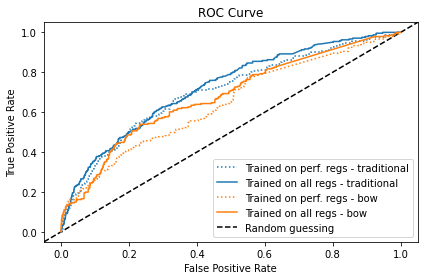

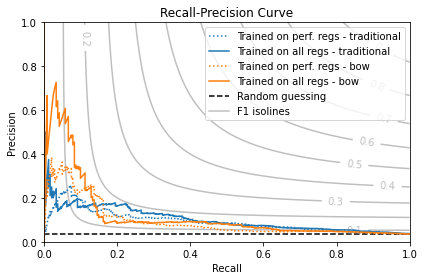

In [35]:
# regression model evaluated on performance regressions
feature_type = 'traditional'

X, y, features = data_map[feature_type][data]('regression')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

reg_model = 'xgb'
reg_pipeline = fit_best_model(reg_model, data, feature_type, 'regression', scoring, X_train, y_train)

X_perf, y_perf, features = data_map[feature_type][data]('performance')
X_perf_train, X_perf_test, y_perf_train, y_perf_test = train_test_split(X_perf, y_perf, test_size=0.1, shuffle=False)

perf_model = 'lr' # best performance model
perf_pipeline = fit_best_model(perf_model, data, feature_type, 'performance', scoring, X_perf_train, y_perf_train)

roc_fig, roc_ax, pr_fig, pr_ax = plot_roc_auc_rec_prec_for_all_models(target, data, feature_type, scoring,
    [('Trained on perf. regs - traditional', perf_pipeline), ('Trained on all regs - traditional', reg_pipeline)],
    X_train, X_test, X_perf_test, y_perf_test, save=False, show=False, figsize=(6,4), ylim=[0,1.],
    colors=['tab:blue','tab:blue'], linestyles=['dotted', 'solid'])


feature_type = 'bow'

X, y, features = data_map[feature_type][data]('regression')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

reg_model = 'xgb'
reg_pipeline = fit_best_model(reg_model, data, feature_type, 'regression', scoring, X_train, y_train)

X_perf, y_perf, features = data_map[feature_type][data]('performance')
X_perf_train, X_perf_test, y_perf_train, y_perf_test = train_test_split(X_perf, y_perf, test_size=0.1, shuffle=False)

perf_model = 'lr' # best performance model
perf_pipeline = fit_best_model(perf_model, data, feature_type, 'performance', scoring, X_perf_train, y_perf_train)

_ = plot_roc_auc_rec_prec_for_all_models(target, data, feature_type, scoring,
    [('Trained on perf. regs - bow', perf_pipeline), ('Trained on all regs - bow', reg_pipeline)],
    X_train, X_test, X_perf_test, y_perf_test, save=False, figsize=(6,4), ylim=[0,1.],
    colors=['tab:orange','tab:orange'], linestyles=['dotted', 'solid'],
    roc_fig=roc_fig, roc_ax=roc_ax, pr_fig=pr_fig, pr_ax=pr_ax)

plt.show()

In [ ]:
vocabulary = {}
for i, f in enumerate(features):
    vocabulary[f] = i

In [ ]:
from src.labeling import *

In [ ]:
hg_to_git, git_to_hg = get_hg_git_mapping()

In [ ]:
fix_and_introducers = read_data_from_json(f'data/labeling/fixed_defect_szz/results/fix_and_introducers_pairs.json')
for pair in fix_and_introducers:
    pair[0] = git_to_hg[pair[0]]
    pair[1] = git_to_hg[pair[1]]

In [9]:
fix_commit = '9c9241d58d525eef5d9228763fd930f3adabc56e'
bug_commit = 'db7fd455cc6af66a965d3ee6f4b3c3a2d00f1a37' #  '97fb4c742d684da863aa27a32ae9d1daa8d67928'

In [ ]:
[(fix, introducer) for fix, introducer in fix_and_introducers if fix == fix_commit]

In [ ]:
fix_and_introducers_df = pd.DataFrame(fix_and_introducers, columns=['fix', 'introducer'])

In [ ]:
introducers = set(fix_and_introducers_df['introducer'])
bug_commit in introducers # check if true positive


In [10]:
F_buglevel = pd.read_csv('data/feature_extractor/features_buglevel.csv')
F_commitlevel = pd.read_csv('data/feature_extractor/features_commitlevel.csv')

In [11]:
rev_to_ix = {rev: i for i, rev in enumerate(F_commitlevel['revision'])}
first_rev_to_ix = {rev: i for i, rev in enumerate(F_buglevel['first_revision'])}

In [13]:
# ix = rev_to_ix[bug_commit]
ix = first_rev_to_ix[bug_commit]
ix

59972

In [14]:
rev_to_ix[bug_commit], first_rev_to_ix[bug_commit]

(87809, 59972)